In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch 

## Load data

<AxesSubplot:xlabel='phi', ylabel='psi'>

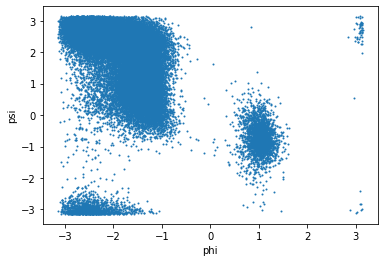

In [1]:
from stateinterpreter import load_dataframe

colvar = load_dataframe('alanine/COLVAR')

colvar.plot.scatter('phi','psi',s=1)

## Compute DeepTICA

In [2]:
X = colvar.filter(regex='d_').values
n_input = X.shape[1]

# Calculate inverse temperature
temp= 300.       
kb=0.008314
beta=1./(kb*temp)

# Extract cvs from df
t = colvar['time'].values # save time
bias = colvar.filter(regex='.bias').values.sum(axis=1) # Load *.bias columns and sum them

# Compute log-weights for time reweighting
logweight = beta*bias

In [3]:
from mlcvs.utils.data import create_time_lagged_dataset, FastTensorDataLoader
from torch.utils.data import Subset,random_split

lag_time = 1.0

# create dataset
dataset = create_time_lagged_dataset(X,t=t,
                                       lag_time=lag_time,
                                       logweights=logweight)

n_train  = int( 0.8 * len(dataset) )
n_valid  = len(dataset) - n_train
train_data, valid_data = random_split(dataset,[n_train,n_valid]) 

# create dataloaders 
train_loader = FastTensorDataLoader(train_data)
valid_loader = FastTensorDataLoader(valid_data)

print('Time-lagged pairs:\t',len(dataset))
print('Training data:\t\t',len(train_data))
print('Validation data:\t',len(valid_data))

/home/lbonati@iit.local/work/mlcvs/mlcvs/utils/plot.py:22: UserWarning: Trying to register the cmap 'fessa' which already exists.
  register_cmap(cmap=cm_fessa)
/home/lbonati@iit.local/work/mlcvs/mlcvs/utils/plot.py:23: UserWarning: Trying to register the cmap 'fessa_r' which already exists.
  register_cmap(cmap=cm_fessa.reversed())


Time-lagged pairs:	 89870
Training data:		 71896
Validation data:	 17974


In [4]:
import torch
from mlcvs.tica import DeepTICA_CV

#------------- PARAMETERS -------------
nodes             = [n_input,30,30,2]
activ_type        = 'tanh'
loss_type         = 'sum2'
n_eig             = 2

lrate             = 1e-3
l2_reg            = 0.

num_epochs        = 1000
earlystop         = True
es_patience       = 10
es_consecutive    = False

log_every         = 10
#--------------------------------------

# DEVICE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MODEL
model = DeepTICA_CV(nodes)
model.to(device)

# OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

# REGULARIZATION
model.set_optimizer(opt)
model.set_earlystopping(patience=es_patience,min_delta=0.,consecutive=es_consecutive, save_best_model=True, log=False)

# TRAIN
model.fit(train_loader,valid_loader,
            standardize_inputs=True,
            standardize_outputs=True,
            loss_type=loss_type,
            n_eig=n_eig,
            nepochs=num_epochs,
            info=False, log_every=log_every)

model.to('cpu')

Epoch Train Loss  Valid Loss  Eigenvalues             
10    -0.439      -0.439      0.546  0.314  
20    -0.962      -0.985      0.817  0.512  
30    -1.126      -1.160      0.918  0.524  
40    -1.171      -1.215      0.941  0.531  
50    -1.197      -1.241      0.951  0.539  
60    -1.222      -1.261      0.957  0.550  
70    -1.239      -1.278      0.960  0.559  
80    -1.255      -1.290      0.964  0.569  
90    -1.269      -1.299      0.967  0.576  
INFO: Early stopping
95    -1.275      -1.302      0.968  0.580  


DeepTICA_CV(
  (nn): Sequential(
    (0): Linear(in_features=45, out_features=30, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=30, out_features=2, bias=True)
  )
)

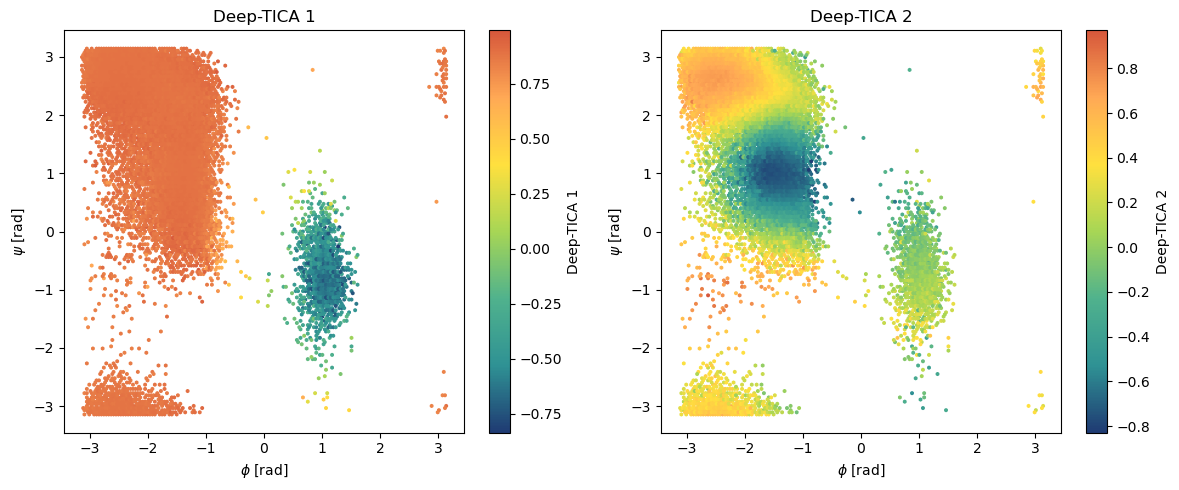

In [8]:
# Hexbin plot in physical space    
fig,axs = plt.subplots(1,n_eig,figsize=(6*n_eig,5),dpi=100)

x = colvar['phi'].values
y = colvar['psi'].values

# compute cvs
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()
    
for i,ax in enumerate(axs):
    pp = ax.hexbin(x,y,C=s[:,i],gridsize=150,cmap='fessa')
    cbar = plt.colorbar(pp,ax=ax)
    ax.set_title('Deep-TICA '+str(i+1))
    ax.set_xlabel(r'$\phi$ [rad]')
    ax.set_ylabel(r'$\psi$ [rad]')
    cbar.set_label('Deep-TICA '+str(i+1))

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='DeepTICA 1', ylabel='DeepTICA 2'>

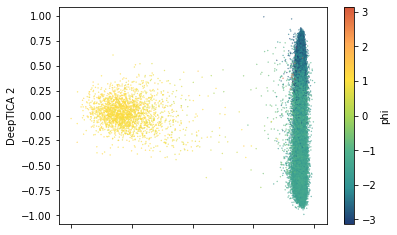

In [21]:
colvar.plot.scatter('DeepTICA 1','DeepTICA 2',c='phi',s=0.1,cmap='fessa')

In [13]:
# evaluate tica cvs and store in colvar dataframe
with torch.no_grad():
    s = model(torch.Tensor(X)).numpy()

for i in range(s.shape[1]):
    colvar[f'DeepTICA {i+1}'] = s[:,i]

In [ ]:
colvar.to_csv('alanine/COLVAR_DeepTICA')